![](https://storage.googleapis.com/kaggle-competitions/kaggle/3136/logos/header.png")

# Kaggle - Titanic 생존자 예측

In [185]:
import numpy as np
import pandas as pd
import graphviz
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import GridSearchCV

## 데이터 적재

### Train 데이터 가져오기

In [116]:
tianic_df = pd.read_csv('./data/titanic/train.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- PassengerId : 탑승객의 아이디 (일련번호)
- Survived : 생존여부 (label,target) (0:사망, 1: 생존)
- Pclass : 선실등급 (1: 1등석, 2: 2등석, 3: 3등석)
- Name : 탑승객의 이름
- Sex : 탑승객의 성별
- Age : 탑승객의 나이
- SibSp	: 같이 탑승한 형제자매 또는 배우자 수
- Parch : 같이 탑승한 부모님 또는 자식 수
- Ticket : 티켓번호 
- Fare : 요금
- Cabin	: 선실번호
- Embarked : 중간 정착 항구 (C: Cherbourg, Q: Queenstown, S: Southhampton)

In [117]:
X_train = titanic_df.drop('Survived',axis=1)
y_train = titanic_df['Survived']

### Test 데이터 가져오기

In [118]:
X_test = pd.read_csv('./data/titanic/test.csv')
y_test = pd.read_csv('./data/titanic/gender_submission.csv')

In [119]:
y_test = y_test.Survived # Survived 컬럼만 예측

In [120]:
# 일단 한 번 결정트리로 생존여부 예측해보자
# 1) Estimator 객체 생성
dt_clf = DecisionTreeClassifier()

In [121]:
# 2) 학습 - fit()
# 학습이 안되는 이유는 String 데이터를 처리할 수 없기 때문
dt_clf.fit(X_train, y_train)

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

## 데이터 전처리

In [122]:
# 문자열 처리
# 문자열을 그냥 삭제하는 방향으로 가자
X_train.info() # Name, Sex, Ticket, Cabin, Embarked가 숫자가 아니다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


In [123]:
# 문자열 피처 삭제
X_train2 = X_train.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'],axis=1)
X_test2 = X_test.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'],axis=1)

In [124]:
# 다시 한번 학습을 시도해보자
# NaN이 있기 때문에 학습이 잘 안되는 것을 볼 수 있다
dt_clf.fit(X_train2, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [125]:
# NaN을 가진 컬럼을 찾아서 처리하자
X_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
dtypes: float64(2), int64(4)
memory usage: 41.8 KB


In [126]:
# NaN 처리 방법
# 1) 해당 데이터 삭제 (Age가 NaN인 탑승객 정보를 미활용)
# 2) Age라는 피처를 미활용하자
# 3) NaN을 특정 값으로 채워넣기
    # 특정 값:
    # 1) 평균값, => 우린 이걸로 채워넣기로 하자
    # 2) 0,
    # 3) 가장 빈도수가 높은 값
X_train2.Age.fillna(X_train2.Age.mean(),inplace=True)
X_test2.Age.fillna(X_test2.Age.mean(),inplace=True)

In [127]:
dt_clf.fit(X_train2, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [128]:
# 특정 피처가 NaN이 있기 때문에 에러 발생
dt_clf.score(X_test2, y_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [129]:
X_test2.info()
# Fare           417 non-null float64
# 여기에서 하나가 누락된 것을 볼 수 있다
# 평균값으로 치환하자

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
dtypes: float64(2), int64(4)
memory usage: 19.7 KB


In [130]:
X_test2.Fare.fillna(X_test2.Fare.mean(), inplace=True)

In [131]:
dt_clf.score(X_train2, y_train)

1.0

In [132]:
dt_clf.score(X_test2, y_test) # 오버피팅 됐다는 사실을 알 수 있다

0.6004784688995215

In [133]:
## 이제 조금 개선해보자
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


In [134]:
# 1. 불필요한 피처 제거
# PassengerId : 탑승객의 일련번호이므로 의미X
# Name : 탑승객의 이름
# Ticket : Ticket의 앞자리로 Ticket의 종류를 파악 가능하긴 함
X_train.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)
X_test.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)

In [135]:
# 문자열 피처 정리
# 문자열 피처 : Sex, Cabin, Embarked
# Sex - LabelEncoding으로 숫자 타입으로 변환
# Cabin - PClass라는 비슷한 특성도 있고, NaN값도 너무 많으므로 미활용
# Embarked - 일단 뭔지 잘 모르겠으니 살리자, OneHotEncoding으로 가자
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 48.8+ KB


In [136]:
# Sex - LabelEncoder로 숫자 타입으로 변환
le = LabelEncoder()
X_train.Sex = le.fit_transform(X_train.Sex)
X_test.Sex = le.fit_transform(X_test.Sex)

In [137]:
le.classes_ # 0이 female이고 1이 male인걸 알 수 있음

array(['female', 'male'], dtype=object)

In [138]:
# Embarked - OneHotEncoding 활용
# Embarked 컬럼에는 2개의 NaN이 존재
# 우선 OneHotEncoding하기 전에 NaN으로 값을 처리
# X_train.Embarked.value_counts()를 통해서 'S'가 가장 빈도수가 높다는 걸 확인
# NaN값을 'S'로 치환하기로 결정
X_train.Embarked.fillna('S',inplace=True)

In [139]:
# pandas의 get_dummies 함수를 통해서 원핫인코딩
ohe_embarked = pd.get_dummies(X_train.Embarked)
X_train = pd.concat([X_train,ohe_embarked],axis=1)
X_train.drop('Embarked',axis=1,inplace=True)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,3,1,22.0,1,0,7.2500,0,0,1
1,1,0,38.0,1,0,71.2833,1,0,0
2,3,0,26.0,0,0,7.9250,0,0,1
3,1,0,35.0,1,0,53.1000,0,0,1
4,3,1,35.0,0,0,8.0500,0,0,1


In [140]:
ohe_embarked = pd.get_dummies(X_test.Embarked)
X_test = pd.concat([X_test,ohe_embarked],axis=1)
X_test.drop('Embarked',axis=1,inplace=True)
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,3,1,34.5,0,0,7.8292,0,1,0
1,3,0,47.0,1,0,7.0000,0,0,1
2,2,1,62.0,0,0,9.6875,0,1,0
3,3,1,27.0,0,0,8.6625,0,0,1
4,3,0,22.0,1,1,12.2875,0,0,1


In [141]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Pclass    891 non-null int64
Sex       891 non-null int64
Age       714 non-null float64
SibSp     891 non-null int64
Parch     891 non-null int64
Fare      891 non-null float64
C         891 non-null uint8
Q         891 non-null uint8
S         891 non-null uint8
dtypes: float64(2), int64(4), uint8(3)
memory usage: 44.5 KB


In [142]:
# Age 피처 처리
# 1) NaN 값 처리 -> 평균으로 치환
X_train.Age.fillna(X_train.Age.mean(), inplace=True)
X_test.Age.fillna(X_test.Age.mean(), inplace=True)

In [143]:
# 2) 나이대라는 새로운 컬럼으로 변경
    # 0~5 : Baby
    # 6~12 : child
    # 13~18 : Teenager
    # 19~35 : Young Adult
    # 36~60 : Adult
    # 61~ : Elderly
X_train['Ages'] = np.digitize(X_train.Age, [6,13,19,36,61])
X_test['Ages'] = np.digitize(X_test.Age, [6,13,19,36,61])
X_train.drop('Age',axis=1, inplace=True)
X_test.drop('Age',axis=1, inplace=True)

In [144]:
X_train.columns, X_test.columns

(Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'C', 'Q', 'S', 'Ages'], dtype='object'),
 Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'C', 'Q', 'S', 'Ages'], dtype='object'))

In [145]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
Pclass    418 non-null int64
Sex       418 non-null int64
SibSp     418 non-null int64
Parch     418 non-null int64
Fare      417 non-null float64
C         418 non-null uint8
Q         418 non-null uint8
S         418 non-null uint8
Ages      418 non-null int64
dtypes: float64(1), int64(5), uint8(3)
memory usage: 20.9 KB


In [146]:
X_test.Fare.fillna(X_test.Fare.mean(),inplace=True)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
Pclass    418 non-null int64
Sex       418 non-null int64
SibSp     418 non-null int64
Parch     418 non-null int64
Fare      418 non-null float64
C         418 non-null uint8
Q         418 non-null uint8
S         418 non-null uint8
Ages      418 non-null int64
dtypes: float64(1), int64(5), uint8(3)
memory usage: 20.9 KB


## 데이터 학습

### Estimator 객체 생성

In [155]:
dt_clf = DecisionTreeClassifier()
svc_clf = SVC(gamma='scale') # Warning을 없애기 위한 파라미터들
lr_clf = LogisticRegression(solver='lbfgs',max_iter = 1000) # Warning을 없애기 위한 파라미터들

### 학습 - fit()

In [156]:
dt_clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [157]:
svc_clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [158]:
lr_clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

### 평가

In [161]:
for estimator in [dt_clf,svc_clf,lr_clf]:
#     print('{}에 대해서'.format(estimator))
    print('TRAIN Acc : {}'.format(estimator.score(X_train,y_train)))
    print('TEST Acc : {}'.format(estimator.score(X_test,y_test)))
    print('-'*50)

TRAIN Acc : 0.9405162738496072
TEST Acc : 0.854066985645933
--------------------------------------------------
TRAIN Acc : 0.6778900112233446
TEST Acc : 0.6507177033492823
--------------------------------------------------
TRAIN Acc : 0.8170594837261503
TEST Acc : 0.937799043062201
--------------------------------------------------


### GridSearchCV()로 하이퍼 파리미터 튜닝

#### DecisionTreeClassifier

In [175]:
# 파라미터들
dt_params = {
    'criterion': ['gini', 'entropy'],  # 불순도
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [10, 20, 30]
}

In [176]:
# 1) GridSearchCV 객체 생성
grid_dt = GridSearchCV(dt_clf, 
                       param_grid=dt_params,
                       cv=5,
                       n_jobs=-1)

In [177]:
# 2) 학습 - fit()
grid_dt.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 7, 9], 'min_samples_split': [10, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [178]:
# 3) 평가 및 결과 확인
# 3-1) 최적의 파라미터 조합
grid_dt.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [179]:
# 3-2) best model로 평가
grid_dt.best_estimator_.score(X_test,y_test)

0.8851674641148325

#### SVC

In [180]:
svc_params = {
    'kernel':['rbf','sigmoid'],
    'degree':[3,5]
}

In [181]:
# 1) SVC으로 GridSearchCV() 생성
grid_svc = GridSearchCV(svc_clf, 
                       param_grid=svc_params,
                       cv=5,
                       n_jobs=-1)

In [182]:
# 2) 학습 - fit()
grid_svc.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'kernel': ['rbf', 'sigmoid'], 'degree': [3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [183]:
# 3) 평가 및 결과 확인
# 3-1) 최적의 파라미터 조합
grid_svc.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [184]:
# 3-2) best model로 평가
grid_svc.best_estimator_.score(X_test,y_test)

0.6507177033492823

## 결정트리 시각화

In [187]:
imp = grid_dt.best_estimator_.feature_importances_
imp

array([0.13695526, 0.41605887, 0.02818831, 0.02892643, 0.26530367,
       0.01769975, 0.        , 0.01092454, 0.09594316])

In [191]:
dt_imp = pd.DataFrame(imp)
dt_imp.index = X_train.columns
dt_imp.T

,Pclass,Sex,SibSp,Parch,Fare,C,Q,S,Ages
0,0.136955,0.416059,0.028188,0.028926,0.265304,0.0177,0.0,0.010925,0.095943


In [207]:
dt_imp.columns = ['importance']

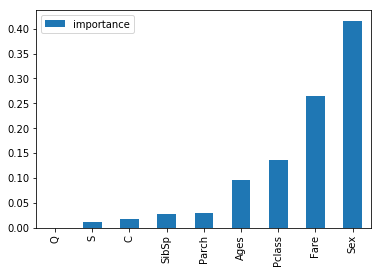

In [208]:
dt_imp.sort_values(by = 'importance').plot(kind='bar')
plt.show()

In [201]:
# 결정트리 시각화
# 시각화를 위해서 
simple_dt = DecisionTreeClassifier(max_depth = 3)
simple_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

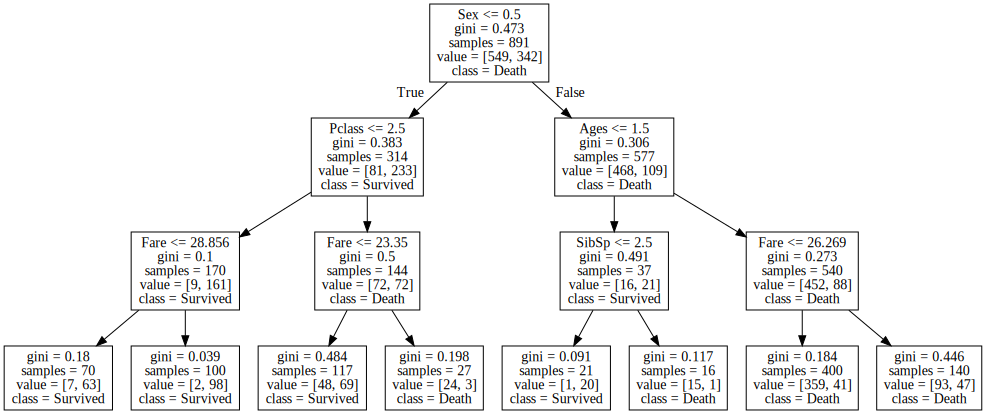

In [205]:
from sklearn import tree
dot_data = tree.export_graphviz(simple_dt,out_file=None,
                                feature_names=X_train.columns,
                               class_names=['Death','Survived'])
graph = graphviz.Source(dot_data)
graph